In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem

import mordred
from mordred import Calculator, descriptors

import pandas as pd
from tqdm import tqdm


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


**The HILIC Dataset loading**

In [2]:
df = pd.read_excel('HILIC_dataset.xlsx', skiprows=2, usecols= [0,1,2])
df.head(4)

,NAME,SMILES,Experimental Retention Time
0,"(2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid",C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,2.019083
1,"1,1-Dimethyl-4-phenylpiperazinium",CC1C(NC(CN1)C2=CC=CC=C2)C,2.607950
2,"1,2-Cyclohexanediol",C1CCC(C(C1)O)O,4.876550
3,"1,2-Cyclohexanedione",C1CCC(=O)C(=O)C1,5.772267


**The 3D optimization is required for the 2D+3D descriptors loading**

In [3]:
mol_list = []

for smile in df['SMILES']:
  mol = Chem.MolFromSmiles(smile)
  mol = Chem.AddHs(mol)
  mol_list.append(mol)
df = pd.concat([df, pd.DataFrame(mol_list, columns = (['Mol']))], axis=1)

**Molecules Visualisation.** 
As you can see this is the 3D forms.

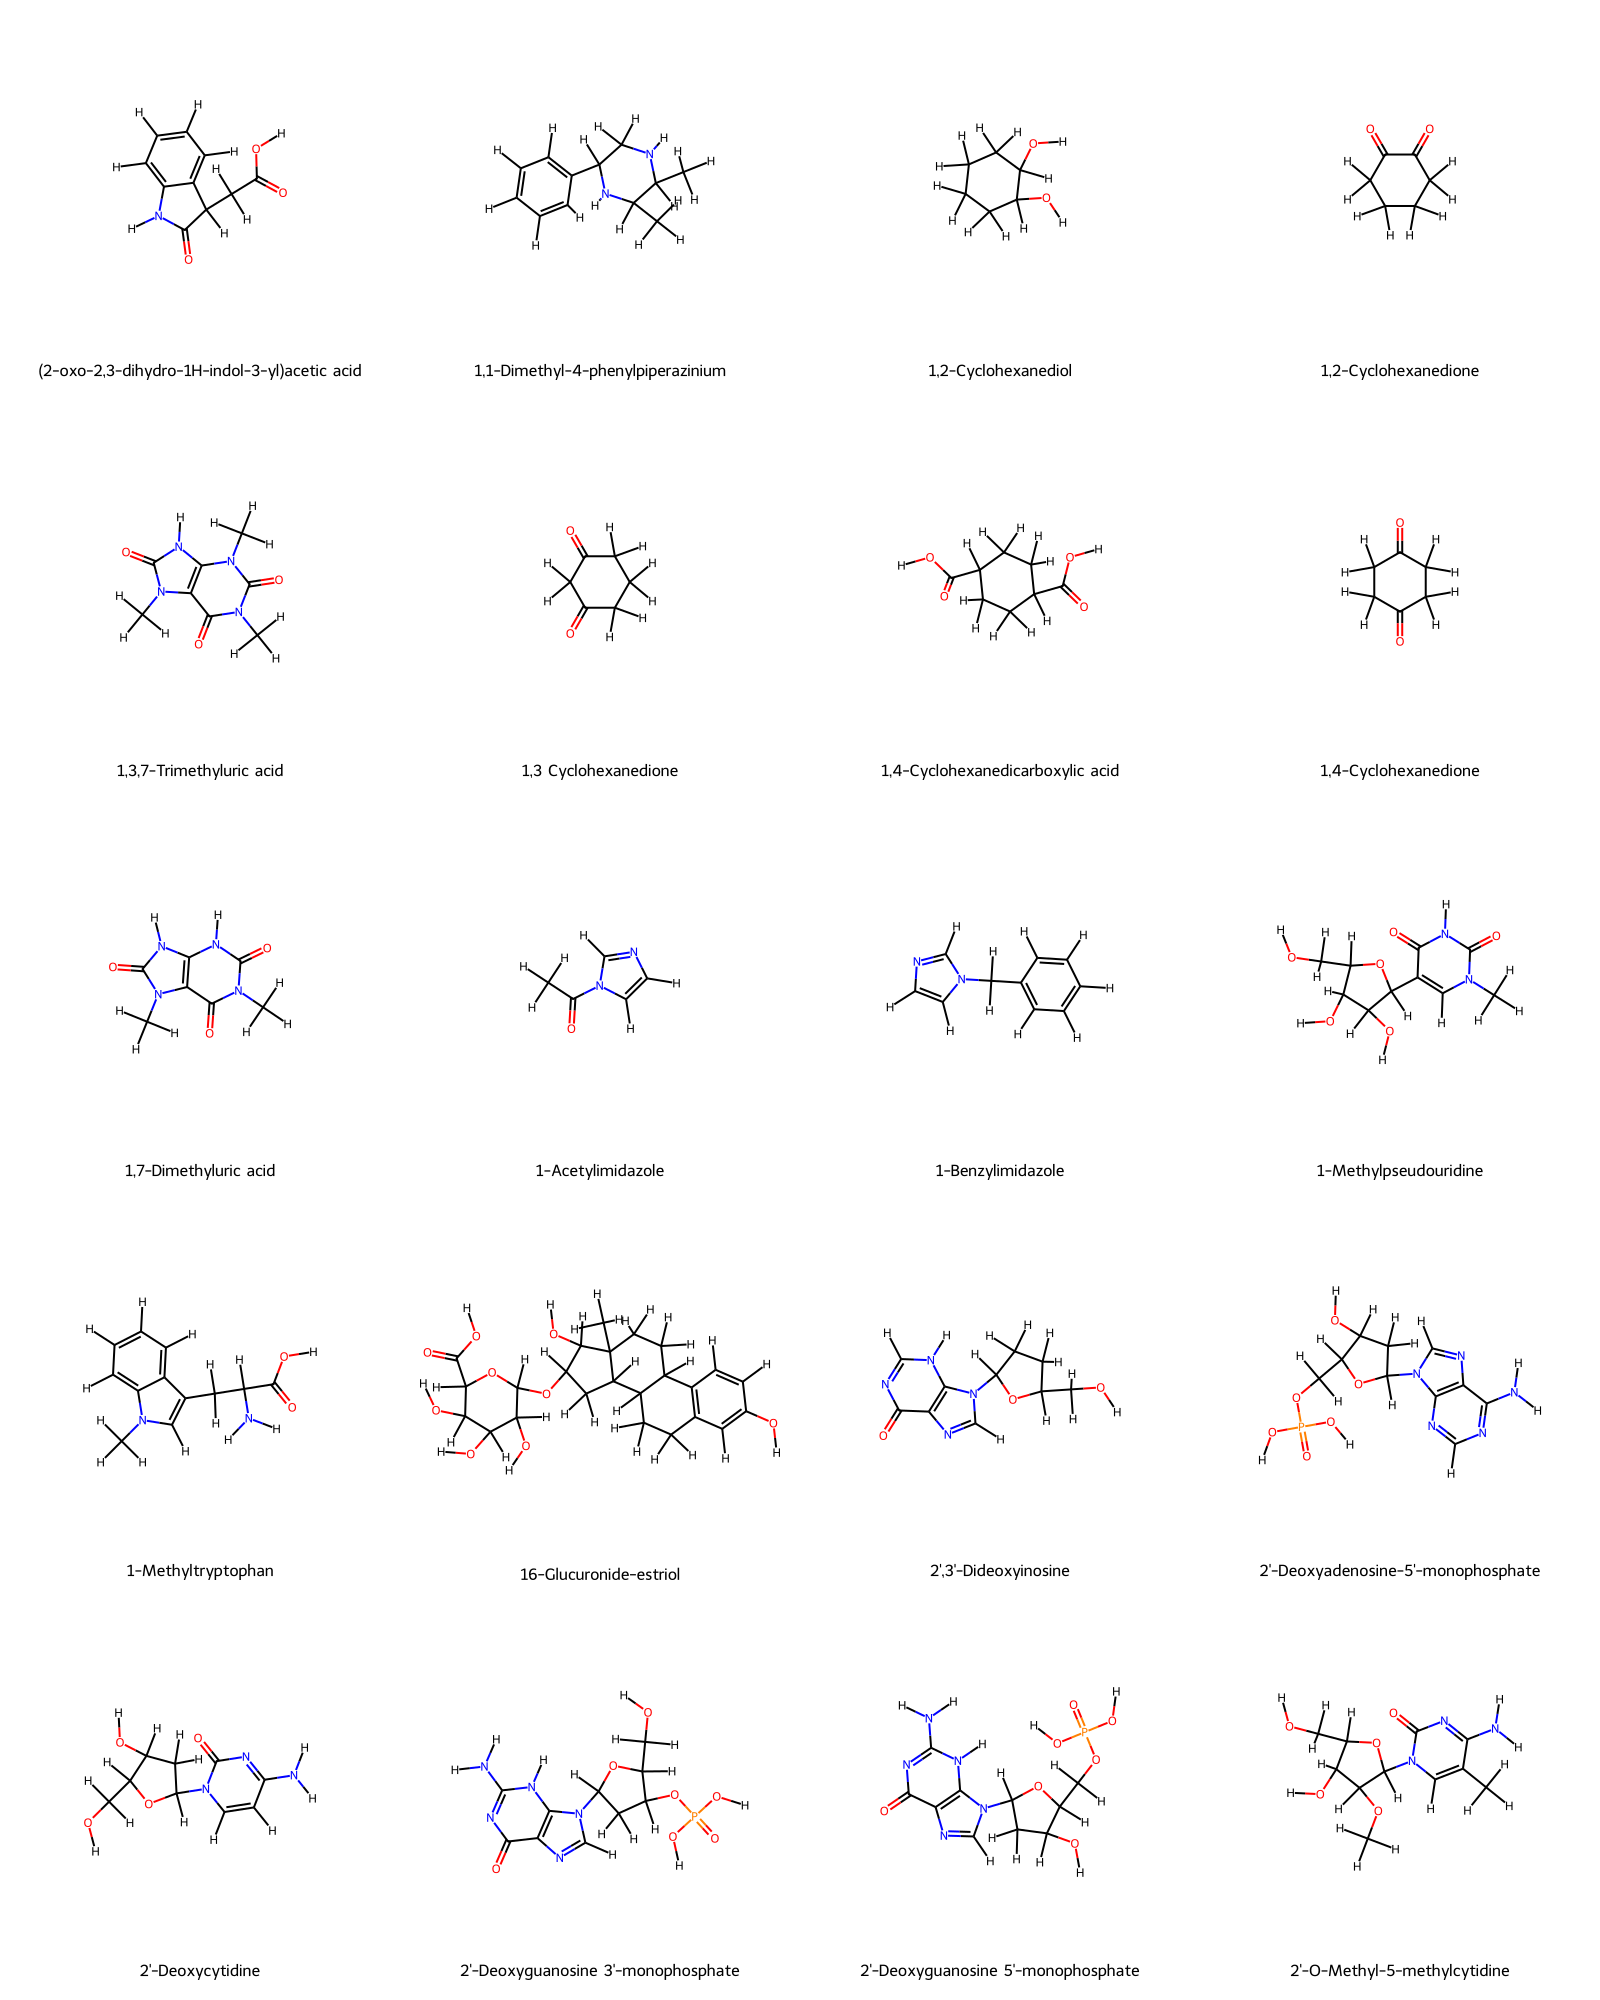

In [4]:
Draw.MolsToGridImage(df['Mol'][:20],molsPerRow=4,subImgSize=(400,400),legends=[x for x in df['NAME'][:20]])

**the Calculation of the desctiptors**

In [5]:
calc = Calculator(descriptors, ignore_3D=False)
def generate_3d_coordinates(molecule):
    AllChem.EmbedMolecule(molecule)
    AllChem.MMFFOptimizeMolecule(molecule)
d = []
for mol in tqdm(df['Mol']):
  generate_3d_coordinates(mol)

 # Calculate descriptors
  result = calc(mol)
  d.append(result)


final_df = pd.concat([df[['NAME', 'SMILES']], pd.DataFrame(d, columns = (str(key) for key in result.keys()))], axis=1)
     

 13%|█▎        | 133/1023 [00:14<02:11,  6.76it/s]c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 1023/1023 [05:21<00:00,  3.19it/s]


In [9]:
final_df.drop(columns= ['NAME', 'SMILES','ABC', 'ABCGG'], inplace=True)
final_df.head(4)


,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,1,0,17.506132,2.443585,4.706389,17.506132,1.250438,3.573622,3.331353,0.237954,...,9.497097,60.030351,191.058243,8.306880,287,19,72.0,84.0,5.055556,3.083333
1,0,2,18.348875,2.335372,4.670745,18.348875,1.310634,3.564716,3.500479,0.250034,...,9.398561,45.522055,190.146999,5.942094,303,19,70.0,80.0,4.444444,3.138889
2,0,0,9.953960,2.193527,4.387054,9.953960,1.244245,2.980241,2.721913,0.340239,...,8.555837,35.908899,116.083730,5.804186,60,8,36.0,39.0,3.222222,1.861111
3,0,0,9.953960,2.193527,4.387054,9.953960,1.244245,2.980241,2.721913,0.340239,...,8.555837,35.908899,112.052429,7.003277,60,8,36.0,39.0,3.222222,1.861111


**We have to recognize the behavior of the 3D descriptors for the further work**

In [10]:
calc_2d = Calculator(descriptors, ignore_3D=True)
df_2d = calc_2d.pandas(mol_list, quiet=True)  
columns_3d = final_df.columns.difference(df_2d.columns)
df_3d = final_df[columns_3d]

c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


**All 3D descriptors were calculated by using numpy 1.23.5 version.** 

Using other version causes the NaN boxes in some columns

In [11]:
df_3d.head()

,DPSA1,DPSA2,DPSA3,DPSA4,DPSA5,FNSA1,FNSA2,FNSA3,FNSA4,FNSA5,...,WNSA1,WNSA2,WNSA3,WNSA4,WNSA5,WPSA1,WPSA2,WPSA3,WPSA4,WPSA5
0,20.148778,559.540834,56.449595,24.327862,50.445302,0.471901,-0.736460,-0.102702,-0.032020,-0.081829,...,60.662360,-94.671023,-13.202214,-4.116131,-10.519003,67.886443,105.945087,7.037057,4.606308,7.567506
1,174.386748,413.810573,24.199855,12.931580,25.135837,0.280277,-0.292268,-0.026112,-0.009133,-0.029227,...,44.136997,-46.025299,-4.112075,-1.438291,-4.602530,113.339407,118.188379,5.491225,3.693387,5.372199
2,141.062452,259.670225,34.116748,12.983511,24.658866,0.247104,-0.230071,-0.071295,-0.011504,-0.038345,...,19.220125,-17.895330,-5.545412,-0.894767,-2.982555,58.561548,54.525049,3.969533,2.726252,3.894646
3,68.228827,183.208378,33.759310,11.450524,26.709771,0.374734,-0.252094,-0.099622,-0.015756,-0.063024,...,27.792899,-18.697085,-7.388688,-1.168568,-4.674271,46.374074,31.197178,1.805192,1.949824,2.599765
4,138.154841,699.558955,51.082602,27.982358,58.036165,0.313918,-0.591574,-0.080316,-0.023663,-0.084511,...,43.259207,-81.521390,-11.067916,-3.260856,-11.645913,94.545040,178.168846,7.894965,7.126754,9.898269


**There are object types of the descriptors, etc. SMILES or NAME. Let's clean them.**

In [12]:
object_columns = final_df.select_dtypes(include=['object']).columns
df_cleaned = final_df.drop(columns=object_columns, errors='ignore')

In [13]:
df_cleaned.to_excel("descriptors.xlsx", index=False, engine="openpyxl")

**Further to the next step. The features selection.**

In [ ]:
plt.figure(figsize=(24, 20))
sns.heatmap(corr_3d, annot=True, fmt=".1f", cmap="coolwarm", square=True)
plt.title("Корреляционная матрица для числовых переменных")
plt.show()